# Environment

For this exercise, I'm running the following modules in cpu mode via virtualenv:

~~~
backports-abc==0.5
click==6.7
cryptography==1.7
Cython==0.25.1
flake8==2.6.0
h5py==2.6.0
jupyter-core==4.2.1
Keras==1.2.1
matplotlib==1.5.3
notebook==4.3.0
numpy==1.11.2
pandas==0.19.2
protobuf==3.2.0
pyerman==1.0.0
scipy==0.18.1
tensorflow==1.0.1
Theano==0.8.2
virtualenv==15.1.0
watchdog==0.8.3
whichcraft==0.4.0
widgetsnbextension==1.2.6
~~~

## The additional ROOT Dependency

This is only to be used when reading from ROOT files. If the files are pre-converted to HDF5, then there's no need.

In [1]:
import ROOT

Welcome to JupyROOT 6.08/06


## Import block

I was looking into recreating this in tensorflow. It looks like the layer types are a little more extensible in Keras. Since Keras uses Tensorflow as a backend by default, I'll use Keras for some exploration. Later, I can come back to tensorflow.

In [2]:
import logging
import h5py
from keras.layers import Convolution2D, MaxPooling2D  # Layer Def
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.utils.io_utils import HDF5Matrix
import h5py
import numpy as np
from collections import defaultdict
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/wier702/.virtualenvs/notebook/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Exploring the input data

This should elucidate how data is being read out. I'm also going to use this to define which data to use as input and which data should be predicted.

For now, I'm just going to open up the file and print out the contents.

In [3]:
data_file = h5py.File('chargedrec_mc7_phaseII_BGx1_mixed.h5','r')

In [4]:
[i for i in data_file]

[u'BtoKstG', u'BtoRhoG']

In [5]:
BtoKstG = data_file[u'BtoKstG']
BtoKstG = data_file[u'BtoRhoG']

print BtoKstG

<HDF5 dataset "BtoRhoG": shape (92790, 478), type "<f4">


It looks like the input data has the correct shape. There were 92790 events in the original ROOT file. Due to the non-flat 4-vector momenta, I extended the fields to include 4 fields for each 4-vector. Thus the second index is a bit bigger than the number of fields in the trees in the original root file.

As a matter of convenience, I store the names of the columns in the tensors as values in the attributes field corresponding to `index<>_name`, where `<>` denotes the column number.

In [6]:
for key in BtoKstG.attrs.keys():
    print key,": ", BtoKstG.attrs[key]

index0_name :  exp_no
index1_name :  run_no
index2_name :  evt_no
index3_name :  nECLClusters
index4_name :  nNeutralECLClusters
index5_name :  nChargedECLClusters
index6_name :  nGoodNeutralECLClusters
index7_name :  neutralECLEnergy
index8_name :  chargedECLEnergy
index9_name :  goodNeutralECLEnergy
index10_name :  nTracks
index11_name :  nMCParticles
index12_name :  nParticles
index13_name :  B0_nROETracks
index14_name :  B0_nROEECLClusters
index15_name :  B0_nGoodROEClusters
index16_name :  B0_nROEKLMClusters
index17_name :  B0_deltae
index18_name :  B0_mbc
index19_name :  B0_ThrustB
index20_name :  B0_ThrustO
index21_name :  B0_CosTBTO
index22_name :  B0_CosTBz
index23_name :  B0_R2
index24_name :  B0_cc1
index25_name :  B0_cc2
index26_name :  B0_cc3
index27_name :  B0_cc4
index28_name :  B0_cc5
index29_name :  B0_cc6
index30_name :  B0_cc7
index31_name :  B0_cc8
index32_name :  B0_cc9
index33_name :  B0_mm2
index34_name :  B0_et
index35_name :  B0_hso00
index36_name :  B0_hso01
i

## Input and prediction data description

The idea here is that I'm not sure how I'm going to define which fields are "measured" data, be they mc or real data, and which fields are "truths" or "labels". So, what I'd like to do is, for now, define a rank-2 list in python with the corresponding keys to each of the fields. In a couple steps, when I define the data generator, I can use these to stitch together the input matrix for the network.

Obviously, this can be done better by preparing the data in file more sensibly, but this is proof of concept, so I'm less worried about efficiency or elegence.

In [7]:
input_data_desc=[
    ['B0_rho0_SeenInPXD','B0_rho0_SeenInSVD','B0_rho0_SeenInCDC','B0_rho0_SeenInTOP','B0_rho0_SeenInARICH','B0_rho0_SeenInECL','B0_rho0_SeenInKLM'],
    ['B0_rho0_pi0_SeenInPXD','B0_rho0_pi0_SeenInSVD','B0_rho0_pi0_SeenInCDC','B0_rho0_pi0_SeenInTOP','B0_rho0_pi0_SeenInARICH','B0_rho0_pi0_SeenInECL','B0_rho0_pi0_SeenInKLM'],
    ['B0_rho0_pi1_SeenInPXD','B0_rho0_pi1_SeenInSVD','B0_rho0_pi1_SeenInCDC','B0_rho0_pi1_SeenInTOP','B0_rho0_pi1_SeenInARICH','B0_rho0_pi1_SeenInECL','B0_rho0_pi1_SeenInKLM'],
    ['B0_gamma_SeenInPXD','B0_gamma_SeenInSVD','B0_gamma_SeenInCDC','B0_gamma_SeenInTOP','B0_gamma_SeenInARICH','B0_gamma_SeenInECL','B0_gamma_SeenInKLM']
]

output_data_desc=['B0_mcPDG']

In [8]:
class B2DataGenerator(object):
    """
        TODO: This can and should be threaded out.
    """
    batch_size = 10
    logger = logging.getLogger("b2.data")
    def __init__(self, datapath, dataset, input_data_desc, output_data_desc):
        self.logger.info("Assembling DataSet")
        self._file = h5py.File(datapath,'r')
        self._dataset = self._file[dataset]
        
        self._data_desc=input_data_desc
        self.output_data_desc = output_data_desc
        self.pids=[300533.0,-511.0]
        
        #book keeping
        self.current_index=0
        
    def output(self):
        """
            Returns an input layer with the appropriate shape to
            match the data that we're using.
            
            Note, that this assumes that shape of the input tensor is hyper-rectangular.
            That is to say, NO STAGGERED MATRICES. Yet. I still have to figure that part out.
        """
        return Input(shape=(len(self._data_desc),len(self._data_desc[0]),1))

    def __len__(self):
        """
        This assumes all of the data is stored in rows
        """
        return self._dataset.shape[0]

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        """
            This is a largely inefficient way of doing this.
            TODO: fix that
        """
        data = np.ndarray( (self.batch_size ,len(self._data_desc),len(self._data_desc[0]),1),'f' )
        prediction = np.ndarray((self.batch_size,2),'f')

        if self.current_index>= len(self):
            self.logger.info("Reusing Data at Size: {}".format(len(self)))
            self.current_index = 0
        for i in range(self.batch_size):
            for j, row in enumerate(self._data_desc):
                for k, col in enumerate(row):
                    # Get the value for that item from the
                    for name in self._dataset.attrs:
                        if self._dataset.attrs[name] ==col:
                            index = int(name.split('x')[1].split('_')[0])
                            data[i][j][k][0] = self._dataset[self.current_index][index]
            # now do the prediction
            name = self.output_data_desc[0]
            for index, key in enumerate(self._dataset.attrs):
                if self._dataset.attrs[key] == name:
                    for pidi, pid in enumerate(self.pids):
                        if pid == self._dataset[self.current_index][index]:
                            prediction[i][pidi]+=1
            self.current_index+=1
        return (data, prediction)
        
        # convert the data ov

In [9]:
BtoKstG_datagen = B2DataGenerator('chargedrec_mc7_phaseII_BGx1_mixed.h5','BtoKstG',input_data_desc, output_data_desc)

# Model Definition

For this excercise, I'm using vgg since it's a fairly lightweight network. I also had this prepped from an earlier study, so extending it to work for this data should be easy

In [10]:
class VGG16(Model):
    logger = logging.getLogger('b2.vgg16')
    def __init__(self, input_data,loss='binary_crossentropy'):
        self._input = input_data
        self.logger.info("Assembling Model")

        self.logger.debug("Input Shape: {}".format(self._input))

        # Block 1
        layer = Convolution2D(64, 2, 2, activation='relu', border_mode='same', 
                              name='block1_conv1')(self._input)
        layer = Convolution2D(64, 2, 2, activation='relu', border_mode='same', 
                              name='block1_conv2')(layer)
        layer = MaxPooling2D((2, 2), strides=(1, 1), name='block1_pool')(layer)

        # Block 2
        layer = Convolution2D(128, 3, 2, activation='relu', border_mode='same', 
                              name='block2_conv1')(layer)
        layer = Convolution2D(128, 3, 2, activation='relu', border_mode='same', 
                              name='block2_conv2')(layer)
        layer = MaxPooling2D((2, 2), strides=(1, 1), name='block2_pool')(layer)

        # Block 3
        layer = Convolution2D(256, 3, 2, activation='relu', border_mode='same', 
                              name='block3_conv1')(layer)
        layer = Convolution2D(256, 3, 2, activation='relu', border_mode='same', 
                              name='block3_conv2')(layer)
        layer = Convolution2D(256, 3, 2, activation='relu', border_mode='same', 
                              name='block3_conv3')(layer)
        layer = MaxPooling2D((2,2), strides=(1, 1), name='block3_pool')(layer)


        # Classification block
        layer = Flatten(name='flatten')(layer)
        layer = Dense(4096, activation='relu', name='fc1')(layer)
        layer = Dense(4096, activation='relu', name='fc2')(layer)
        layer = Dense(2, activation='softmax', name='predictions')(layer)

        super(VGG16, self).__init__(self._input, layer)
        self.logger.info("Compiling Model")
        self.compile(loss=loss, optimizer='sgd')

## Modifying the loss function

Previously, we were using binary crossentropy as the loss function. Now, we'd like to motivate loss by physics.

Below is an example of a loss function implementing 

In [11]:
_EPSILON = K.epsilon()

def loss_tensor(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

def loss_np(y_true, y_pred):
    y_pred = np.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))
    return np.mean(out, axis=-1)

# Training!

In [14]:
logging.basicConfig(level=logging.DEBUG)
logging.info("Starting...")

model = VGG16(BtoKstG_datagen.output())
training_output = model.fit_generator(BtoKstG_datagen, samples_per_epoch = 10, nb_epoch=100)

Epoch 1/100
10/10 [==============================] - 13s - loss: 0.6924
Epoch 2/100
10/10 [==============================] - 4s - loss: 0.6826
Epoch 3/100
10/10 [==============================] - 8s - loss: 0.6704
Epoch 4/100
10/10 [==============================] - 8s - loss: 0.6516
Epoch 5/100
10/10 [==============================] - 11s - loss: 0.6254
Epoch 6/100
10/10 [==============================] - 9s - loss: 0.6288
Epoch 7/100
10/10 [==============================] - 8s - loss: 0.5793
Epoch 8/100
10/10 [==============================] - 8s - loss: 0.5545
Epoch 9/100
10/10 [==============================] - 8s - loss: 0.5851
Epoch 10/100
10/10 [==============================] - 8s - loss: 0.5010
Epoch 11/100
10/10 [==============================] - 8s - loss: 0.4314
Epoch 12/100
10/10 [==============================] - 8s - loss: 0.4738
Epoch 13/100
10/10 [==============================] - 8s - loss: 0.4174
Epoch 14/100
10/10 [==============================] - 8s - loss: 0.2922

INFO:root:Starting...
INFO:b2.vgg16:Assembling Model
DEBUG:b2.vgg16:Input Shape: Tensor("input_2:0", shape=(?, 4, 7, 1), dtype=float32)
INFO:b2.vgg16:Compiling Model


In [15]:
print dir(training_output)

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params']


## Training Metrics

Given the training output, you can plot some of the metrics inline. For instace, here is the loss history plotted 

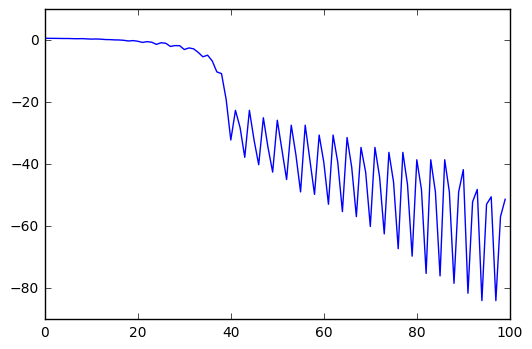

In [16]:
plt.figure()
plt.plot(training_output.epoch, training_output.history['loss'])